# Slim-SOENs Overview

In [1]:
# General imports
import numpy as np
import matplotlib.pyplot as plt

# Add source directory to path 
# (may depend on machine specific directory organization)
import sys
sys.path.append('../slim_soens')

# Import necessary slim-soens tools
from neuron import Neuron
from network import Network
from plotting import *
from system_functions import *

## At A Glance
### The Simplest Neuron
 - The below code will generate a 'point' neuron (one soma, one synapse)
 - The `Neuron` class can be used to construct arbitrary morphologies

In [2]:
sample_neuron = Neuron(
    name = "sample_neuron", # key-word arguments can be used to define neuron param
    threshold = 0.5         # for example, this will define spiking threshold of soma
)
sample_neuron.parameter_print() # a way to check work (don't worry about this for now)

Neuron sample_neuron parameters:
   0 id                    0
   1 name                  sample_neuron
   2 weights               [[[]]]
   3 arbor_params          [[[]]]
   4 synaptic_strength     1
   5 no_synapses           False
   6 threshold             0.5
   7 dendrite_list         [<components.Soma object at 0x0000019F89B94280>, <components.Refractory object at 0x0000019F89CCF6D0>]
   8 dend_soma             <components.Soma object at 0x0000019F89B94280>
   9 dend_ref              <components.Refractory object at 0x0000019F89CCF6D0>
   10 arbor_adjacency       [[ 0.    0.  ]
 [-0.85  0.  ]]
   11 synapse_list          [<components.Synapse object at 0x0000019F89CCF010>]
   12 dims                  [2, 0]
   13 layers                2


### Input and Running

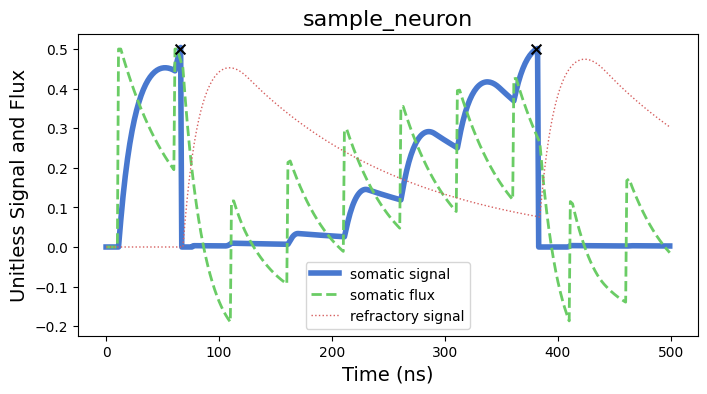

In [3]:
# Input can take the from of an np.array of spike-times
duration = 500
in_spikes = np.arange(10,duration,50)

# This can be added to all available synapses
sample_neuron.add_uniform_input(in_spikes)

# slim-soens simulates networks, even if on of one neuron
sample_net = Network(
    run_simulation = True,              # network can be run automatically upon creation
    nodes          = [sample_neuron],   # there could be many interconnected nodes in this list
    duration       = duration,          # how long to simulate (in nanoseconds)
    ib             = 1.8,               # set serial bias for whole network
)

plot_nodes([sample_neuron]) # plot

sample_net.clear_net() # clear net (for re-use)

### Dendritic Arbors
 - SOEN systems prefer limited fan-in
 - Therefore benefit from dendritc arbors to faciliate greater number of incoming connections

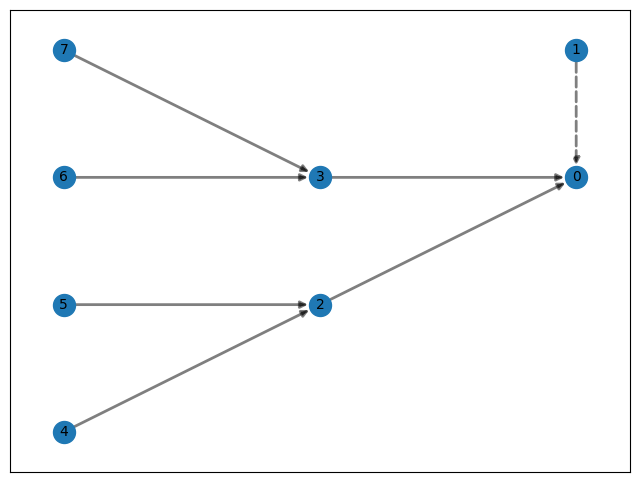

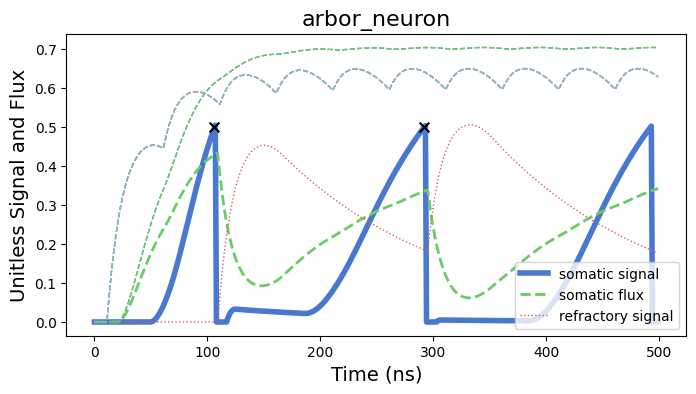

In [4]:
# Here, the weights argument defines the dendritic structure
arbor_neuron = Neuron(
    name = "arbor_neuron",
    weights = [
        [[0.2,0.5]],
        [[0.4,0.3],[0.1,0.6]]
        ]
)

# Plot structure with networkx
arbor_neuron.plot_structure()

# Add input (uniformly to all synapses)
duration = 500
in_spikes = np.arange(10,duration,50)
arbor_neuron.add_uniform_input(in_spikes)

# Create and run network
arbor_net = Network(
    run_simulation = True,
    nodes          = [arbor_neuron],
    duration       = duration,
)

plot_nodes(arbor_net.nodes,dendrites = True)
arbor_net.clear_net()

### All Electrical Networks
 - Dendrites can also be feed with input flux time series directy
 - By initializing without synapses, simulation time can be reduced

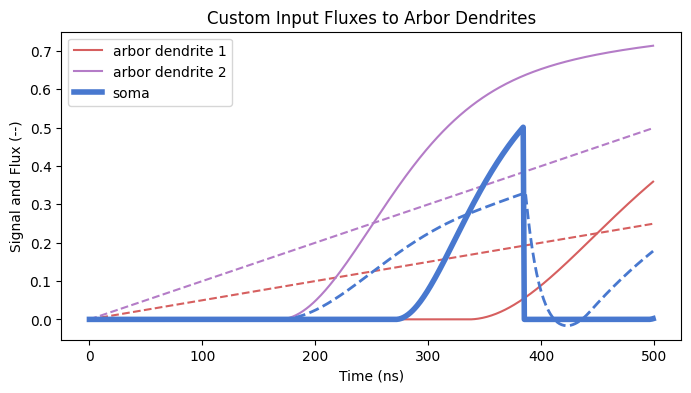

In [5]:
# Here, the weights argument defines the dendritic structure
electical_neuron = Neuron(
    name = "electical_neuron",
    weights = [[[0.2,0.5]]],
    no_synapses = True, # prevents automatic generation of synapses (saves sim time)
)

duration = 500
for d,dend in enumerate(electical_neuron.dendrite_list[2:]): # skip soma and refractory dendrite
    dend.input_flux = (np.arange(0,duration,1)/duration)*0.25*(d+1)

# Create and run network
electical_net = Network(
    run_simulation = True,
    nodes          = [electical_neuron],
    duration       = duration,
)

dend1 = electical_neuron.dendrite_list[2]
dend2 = electical_neuron.dendrite_list[3]
soma  = electical_neuron.dendrite_list[0]

plt.style.use('seaborn-v0_8-muted')
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
plt.figure(figsize=(8,4))

plt.plot(dend1.flux,'--',color=colors[2])
plt.plot(dend2.flux,'--',color=colors[3])

plt.plot(dend1.signal,color=colors[2],label="arbor dendrite 1")
plt.plot(dend2.signal,color=colors[3],label="arbor dendrite 2")

plt.plot(soma.flux,'--',color=colors[0],linewidth=2)
plt.plot(soma.signal,color=colors[0],label="soma",linewidth=4)

plt.title("Custom Input Fluxes to Arbor Dendrites")
plt.ylabel("Signal and Flux (--)")
plt.xlabel("Time (ns)")
plt.legend()
plt.show()

arbor_net.clear_net()

### Custom Dendritic Connections
 - Dendrites can be added to a neuron post-hoc

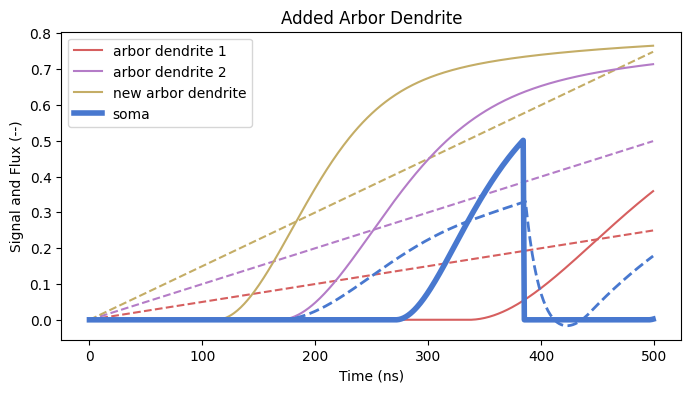

In [6]:
from components import *

base_neuron = Neuron(
    name = "base_neuron",
    weights = [[[0.2,0.5]]],
    no_synapses = True, # prevents automatic generation of synapses (saves sim time)
)

new_dend = Dendrite(name="random dend")

new_dend.outgoing.append([soma,1])
soma.incoming.append([new_dend,1])
base_neuron.dendrite_list.append(new_dend)

electical_neuron.normalize_fanin_symmetric(fanin_factor=1)

duration = 500
for d,dend in enumerate(base_neuron.dendrite_list[2:]): 
    dend.input_flux = (np.arange(0,duration,1)/duration)*0.25*(d+1)

base_net = Network(
    run_simulation = True,
    nodes          = [base_neuron],
    duration       = duration,
)

dend1 = base_neuron.dendrite_list[2]
dend2 = base_neuron.dendrite_list[3]
soma  = base_neuron.dendrite_list[0]

plt.style.use('seaborn-v0_8-muted')
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
plt.figure(figsize=(8,4))

plt.plot(dend1.flux,'--',color=colors[2])
plt.plot(dend2.flux,'--',color=colors[3])
plt.plot(new_dend.flux,'--',color=colors[4])

plt.plot(dend1.signal,color=colors[2],label="arbor dendrite 1")
plt.plot(dend2.signal,color=colors[3],label="arbor dendrite 2")
plt.plot(new_dend.signal,color=colors[4],label="new arbor dendrite")

plt.plot(soma.flux,'--',color=colors[0],linewidth=2)
plt.plot(soma.signal,color=colors[0],label="soma",linewidth=4)

plt.title("Added Arbor Dendrite")
plt.ylabel("Signal and Flux (--)")
plt.xlabel("Time (ns)")
plt.legend()
plt.show()

arbor_net.clear_net()

### Steady-State Regime
 - If input is fed in as flux offest, then temporal dynamics will reach a steady state
 - This can be exploited to derive directly the eventual state of the system
 - Theshold is set arbitrarily high for soma and output is considered in terms of signal
 - Simulations can be run *much* faster with this method
 - Do not capture temporal dynamics, however, and therefore would not be suitable for RNNs

In [41]:
# Here, the weights argument defines the dendritic structure
steady_neuron = Neuron(
    name = "steady_neuron",
    weights = [[[0.2,0.5]]],
    no_synapses = True, 
)

duration = 500
for d,dend in enumerate(steady_neuron.dendrite_list[2:]):
    dend.flux_offset = .3*(d+1)

# Create and run network
steady_net = Network(
    run_simulation = True,
    nodes          = [steady_neuron],
    duration       = duration,
    backend        = "steady_state"
)


print("Final States")
for dend in steady_neuron.dendrite_list:
    print(dend.name,np.round(dend.signal,2))

Final States
steady_neuron_dend_soma 0.72
steady_neuron_dend_ref 0.0
steady_neuron_dend_1_0_0 0.6
steady_neuron_dend_1_0_1 0.75


### Hopfield Networks
 - Example of a network class approach

[[0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]]


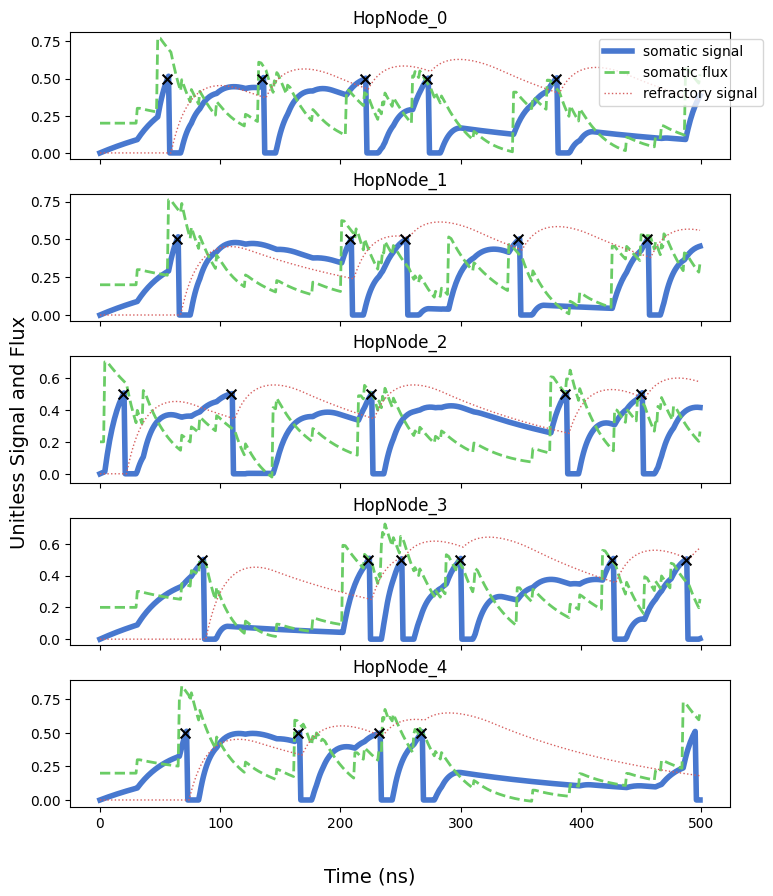

In [ ]:
from network import HopfieldNetwork
N = 5
hop = HopfieldNetwork(
    N                    = N,   # number of neurons in network
    connection_strengths = 1/N, # connection strength between neurons
    global_offset        = .2   # global flux offset for all somas (can array over time)
    )
print(hop.network_adjacency)
for i,node in enumerate(hop.nodes):
    rand_spikes = np.random.rand(10)*duration
    rand_spikes.sort()
    node.synapse_list[0].spike_times = rand_spikes
hop.run_network_simulation(duration=500)
plot_nodes(hop.nodes)

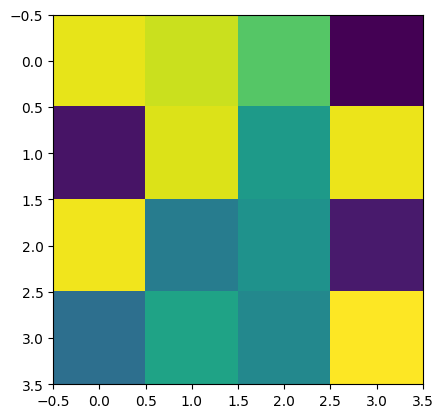

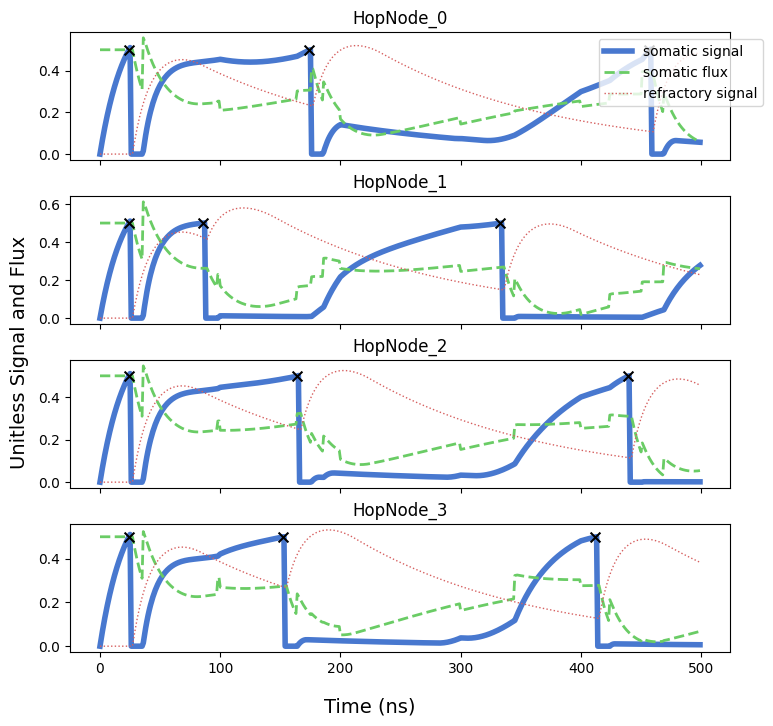

In [ ]:
N = 4
adjacency = np.random.rand(N,N)/N
anneal_phases = 5
duration = 500
steady_decay = False
plt.imshow(adjacency)
plt.show()

# adjacency-defined hopfield network
hop = HopfieldNetwork(network_adjacency=adjacency)

# add specified input (when .flux_offset is an array)
for i,node in enumerate(hop.nodes):

    # steadily decaying input
    if steady_decay == True:
        node.dend_soma.flux_offset = [(.5/(1+.0075*t)) for t in range(duration)]

    # decay in phases
    else:
        node.dend_soma.flux_offset = np.concatenate(
            [np.ones(int(duration/anneal_phases))*(.5/(1+.1*ap)) 
             for ap in range(anneal_phases)]
        )


hop.run_network_simulation(duration=duration)
plot_nodes(hop.nodes)

## Input Methods

## Plotting Tools

## Components

## Supervised Learning

## Backends

## Demo